# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pyswarms as ps
import glob
import os
import importlib
import matplotlib.animation as animation

from scipy.io import mmread
from sklearn.metrics import pairwise_distances, silhouette_score
from scipy.spatial.distance import cdist
from pyswarms.utils.plotters.formatters import Mesher, Designer
from pyswarms.utils.plotters import plot_cost_history, plot_contour, plot_surface
from pyswarms.utils.functions import single_obj as fx
from functools import partial
from IPython.display import HTML

import src.pbmc3k_SI as SI
importlib.reload(SI)

<module 'src.pbmc3k_SI' from 'd:\\Luca\\Documents\\GitHub\\BDA-project\\notebooks\\src\\pbmc3k_SI.py'>

# Import data

In [3]:
# ----------------------------------------
# 1. Load PCA and t-SNE Projections
# ----------------------------------------
pca_df = pd.read_csv("data/pbmc3k/analysis/pca/projection.csv")
tsne_df = pd.read_csv("data/pbmc3k/analysis/tsne/projection.csv")

# ----------------------------------------
# 2. Load Each K-Means Clustering File
# ----------------------------------------
cluster_files = sorted(glob.glob("data/pbmc3k/analysis/kmeans/*_clusters/clusters.csv"))

In [4]:
print(pca_df.shape)
pca_df.head()

(2700, 11)


,Barcode,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10
0,AAACATACAACCAC-1,-0.036339,-0.000549,0.000794,-0.017012,-0.003211,0.000438,0.004646,0.004670,0.006514,0.006905
1,AAACATTGAGCTAC-1,-0.008351,-0.011447,-0.015221,0.054502,0.008977,0.006034,0.001642,-0.006621,0.001067,-0.002333
2,AAACATTGATCAGC-1,-0.025257,0.011896,0.020833,-0.023106,0.011805,0.019217,-0.010754,-0.009297,-0.001191,-0.001945
3,AAACCGTGCTTCCG-1,0.081885,-0.015384,-0.003240,-0.003404,0.002646,0.015661,0.006271,-0.008011,-0.002094,0.001491
4,AAACCGTGTATGCG-1,0.020021,0.053305,0.068235,0.027632,-0.029962,-0.043100,0.029034,0.017645,-0.008180,0.008114


In [5]:
print(tsne_df.shape)
tsne_df.head()

(2700, 3)


,Barcode,TSNE-1,TSNE-2
0,AAACATACAACCAC-1,11.849575,-2.530312
1,AAACATTGAGCTAC-1,-5.155488,-28.677855
2,AAACATTGATCAGC-1,-4.761947,6.883890
3,AAACCGTGCTTCCG-1,-11.358188,27.867571
4,AAACCGTGTATGCG-1,-21.883776,-13.640626


In [6]:
clusters_df = pd.read_csv(cluster_files[4])
print(clusters_df.shape)
clusters_df.head()

(2700, 2)


,Barcode,Cluster
0,AAACATACAACCAC-1,2
1,AAACATTGAGCTAC-1,5
2,AAACATTGATCAGC-1,2
3,AAACCGTGCTTCCG-1,1
4,AAACCGTGTATGCG-1,3


In [7]:
data_tsne = tsne_df.drop(columns=["Barcode"]).values

# Old Analysis

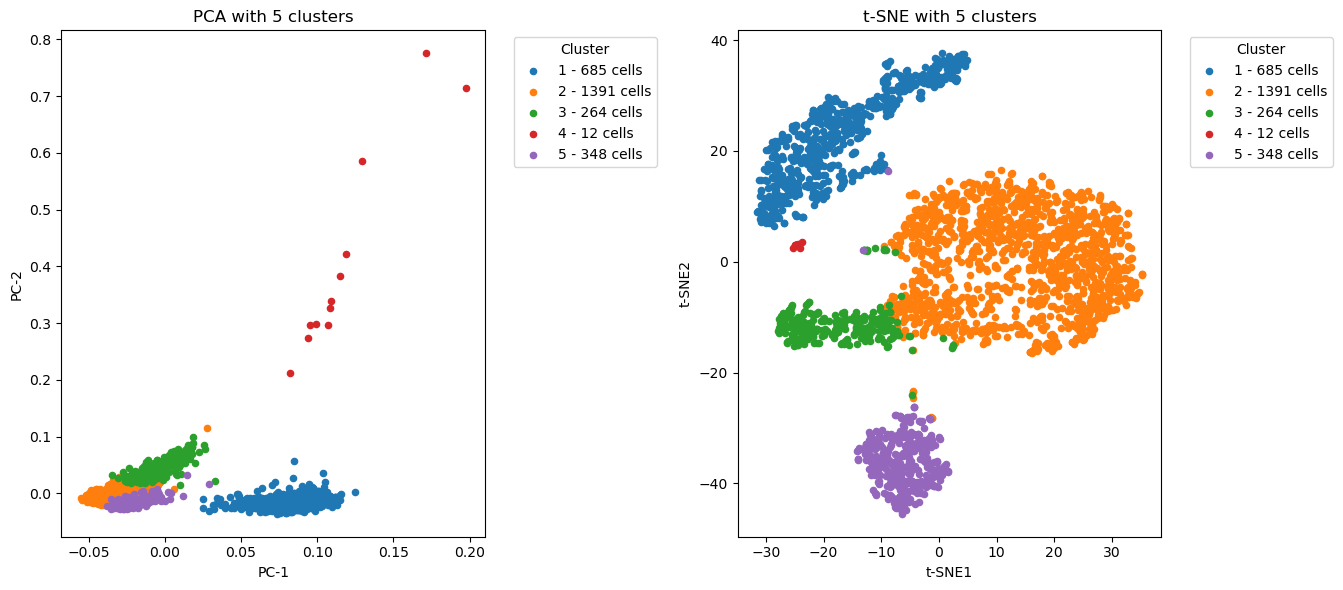

In [8]:
# ----------------------------------------
# 3. Merge with PCA and t-SNE Data
# ----------------------------------------
merged_pca = pd.merge(pca_df, clusters_df, on="Barcode", how="inner")
merged_tsne = pd.merge(tsne_df, clusters_df, on="Barcode", how="inner")

# ----------------------------------------
# 4. Plotting
# ----------------------------------------
# Increase figure width to make images broader
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Use a more distinct categorical palette (e.g., "tab10")
unique_clusters = sorted(merged_pca["Cluster"].unique())
palette = sns.color_palette("tab10", n_colors=len(unique_clusters))

# ---------------------------
# (A) PCA Scatter
# ---------------------------
for i, cluster_label in enumerate(unique_clusters):
    subset = merged_pca[merged_pca["Cluster"] == cluster_label]
    ax[0].scatter(
        subset["PC-1"], 
        subset["PC-2"],
        color=palette[i],
        s=20,
        label=f"{cluster_label} - {len(subset)} cells"
    )

ax[0].set_title("PCA with 5 clusters")
ax[0].set_xlabel("PC-1")
ax[0].set_ylabel("PC-2")
ax[0].legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Cluster")

# ---------------------------
# (B) t-SNE Scatter
# ---------------------------
for i, cluster_label in enumerate(unique_clusters):
    subset = merged_tsne[merged_tsne["Cluster"] == cluster_label]
    ax[1].scatter(
        subset["TSNE-1"], 
        subset["TSNE-2"],
        color=palette[i],
        s=20,
        label=f"{cluster_label} - {len(subset)} cells"
    )

ax[1].set_title("t-SNE with 5 clusters")
ax[1].set_xlabel("t-SNE1")
ax[1].set_ylabel("t-SNE2")
ax[1].legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Cluster")

# Adjust layout to provide space for legends outside the axes
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [9]:
results = {}
kmeans_silhouette_score = silhouette_score(data_tsne, clusters_df["Cluster"])
results["KMeans"] = {"cost": -1, "silhouette": kmeans_silhouette_score}
print(f"K-Means Silhouette Score: {kmeans_silhouette_score:.3f}")

K-Means Silhouette Score: 0.382


# New Analysis

In [10]:
# Assume tsne_df is a DataFrame with a 'Barcode' column and two t-SNE coordinate columns.
# Convert tsne_df to a numeric array (ignoring the 'Barcode'):
data_tsne = tsne_df.drop(columns=["Barcode"]).values  # shape: (n_cells, 2)

n_clusters = 5
iters = 100
n_particles = 30

In [258]:
# Run PSO
start = time.time()
pso_cost, pso_centers, pso_labels, pso_sil, pso_pos_history, pso_cost_history = SI.run_pso(data_tsne, n_clusters, iters, n_particles, record_history=True)
results["PSO"] = {"cost": pso_cost, "silhouette": pso_sil}
print("PSO run time: {:.2f} seconds".format(time.time() - start))

PSO run time: 3.61 seconds


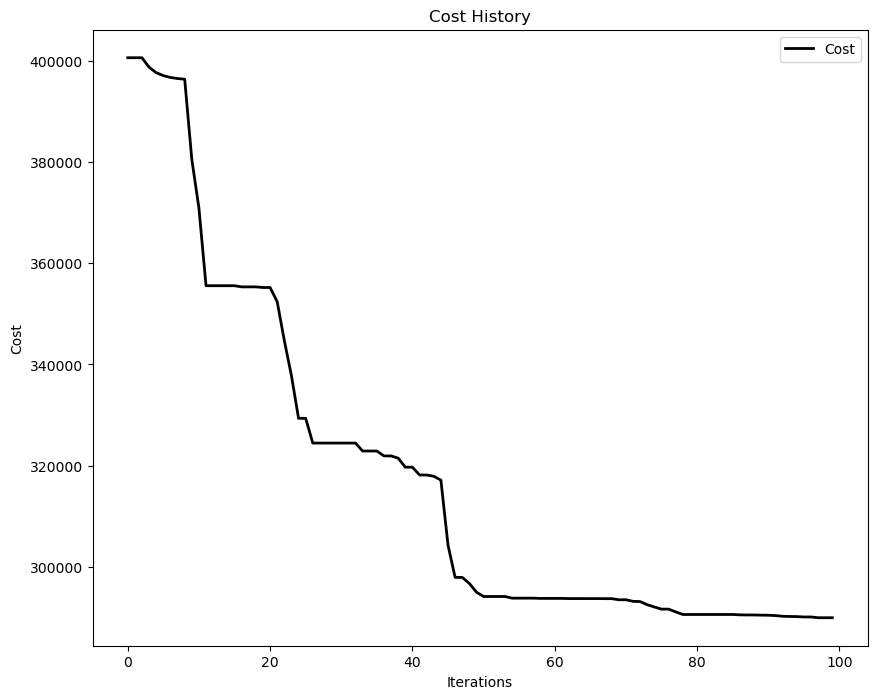

In [259]:

plot_cost_history(cost_history=pso_cost_history)
plt.show()

2025-04-15 17:53:14,926 - matplotlib.animation - WARNING - MovieWriter imagemagick unavailable; using Pillow instead.
2025-04-15 17:53:14,928 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


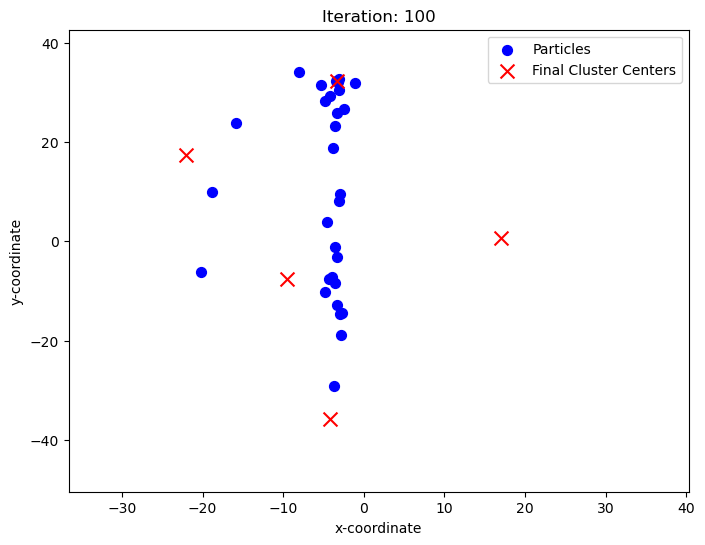

In [260]:
# Create the animation
ani = SI.animate_sa(data_tsne, pso_pos_history, pso_centers)

# Save the animation as a GIF using imagemagick writer
ani.save('../results/pbmc3k/pso_animation.gif', writer='imagemagick', fps=10)

In [261]:
# Run ABC
start = time.time()
abc_cost, abc_centers, abc_labels, abc_sil, abc_history = SI.run_abc(data_tsne, n_clusters, iters, n_food_sources=30, limit=20, record_history=True)
results["ABC"] = {"cost": abc_cost, "silhouette": abc_sil}
print("ABC run time: {:.2f} seconds".format(time.time() - start))

ABC run time: 2.24 seconds


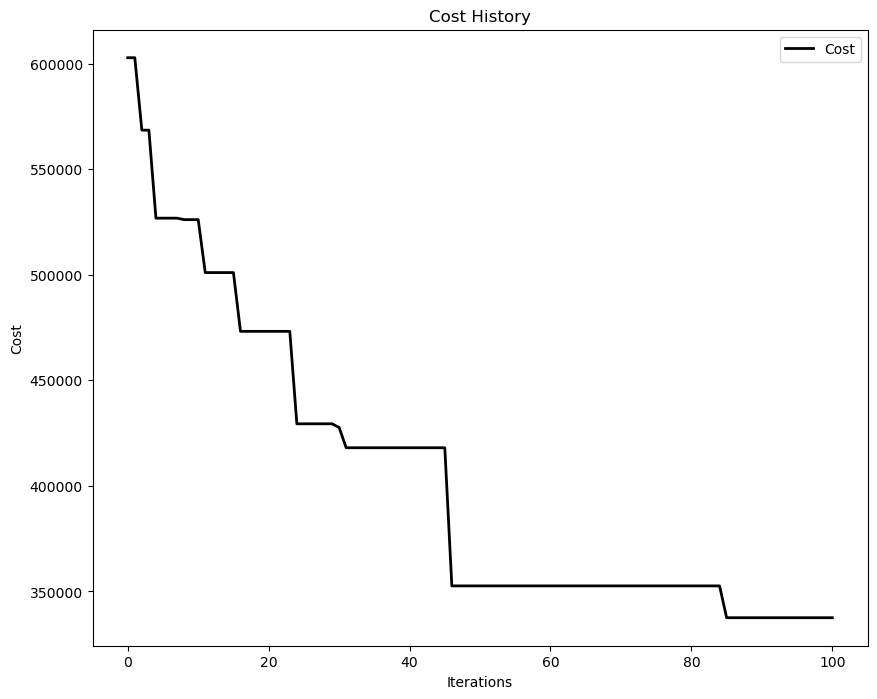

In [262]:
plot_cost_history(cost_history=abc_history["costs"])
plt.show()

2025-04-15 17:53:32,256 - matplotlib.animation - WARNING - MovieWriter imagemagick unavailable; using Pillow instead.
2025-04-15 17:53:32,257 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


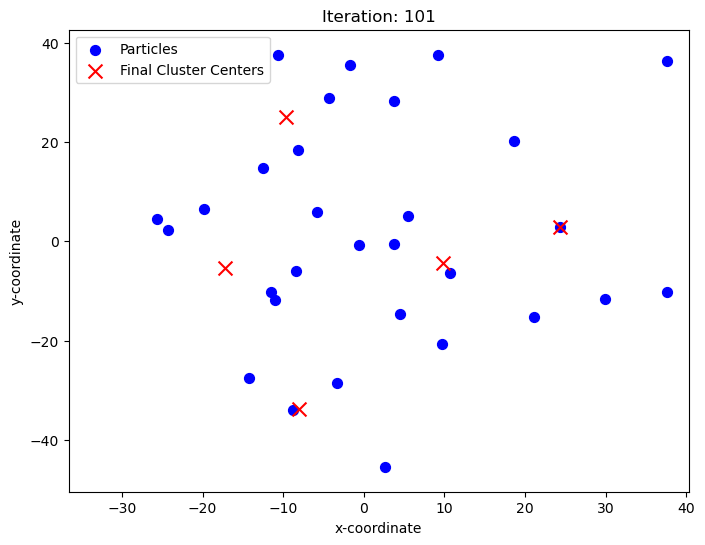

In [263]:
ani = SI.animate_sa(data_tsne, abc_history["positions"], abc_centers)
ani.save('../results/pbmc3k/abc_animation.gif', writer='imagemagick', fps=10)

In [264]:
# Run ACOR (ACO variant)
start = time.time()
acor_cost, acor_centers, acor_labels, acor_sil, acor_history = SI.run_acor(data_tsne, n_clusters, iters, archive_size=30, ants=30, q=0.5, xi=0.85, record_history=True)
results["ACOR"] = {"cost": acor_cost, "silhouette": acor_sil}
print("ACOR run time: {:.2f} seconds".format(time.time() - start))

ACOR run time: 2.27 seconds


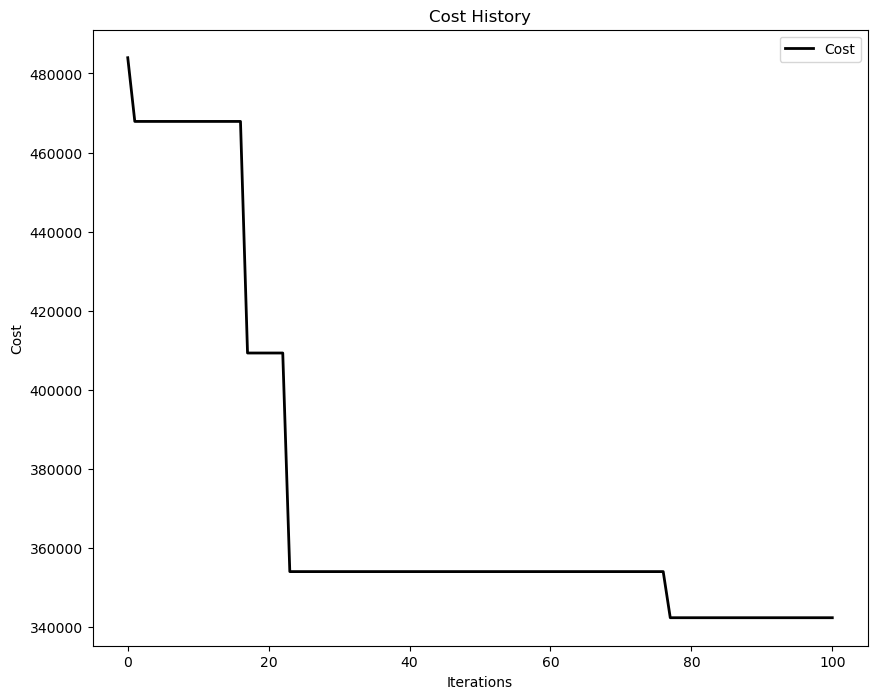

In [265]:
plot_cost_history(cost_history=acor_history["costs"])
plt.show()

2025-04-15 17:53:48,348 - matplotlib.animation - WARNING - MovieWriter imagemagick unavailable; using Pillow instead.
2025-04-15 17:53:48,349 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


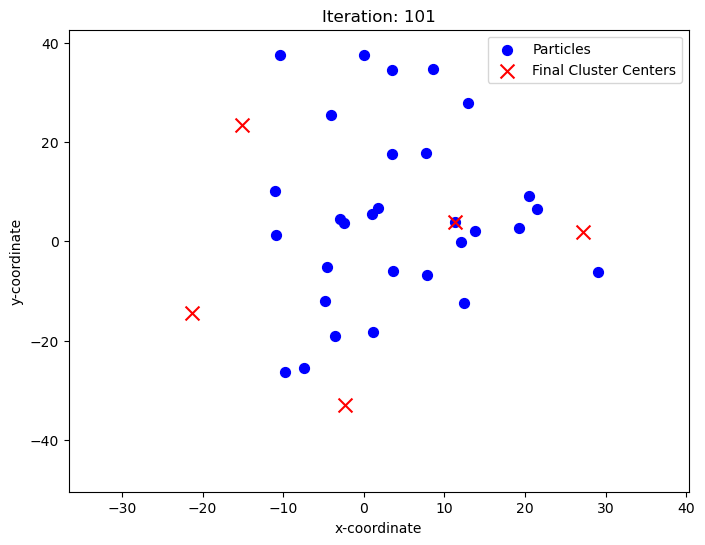

In [266]:
ani = SI.animate_sa(data_tsne, acor_history["archives"], acor_centers)
ani.save('../results/pbmc3k/acor_animation.gif', writer='imagemagick', fps=10)

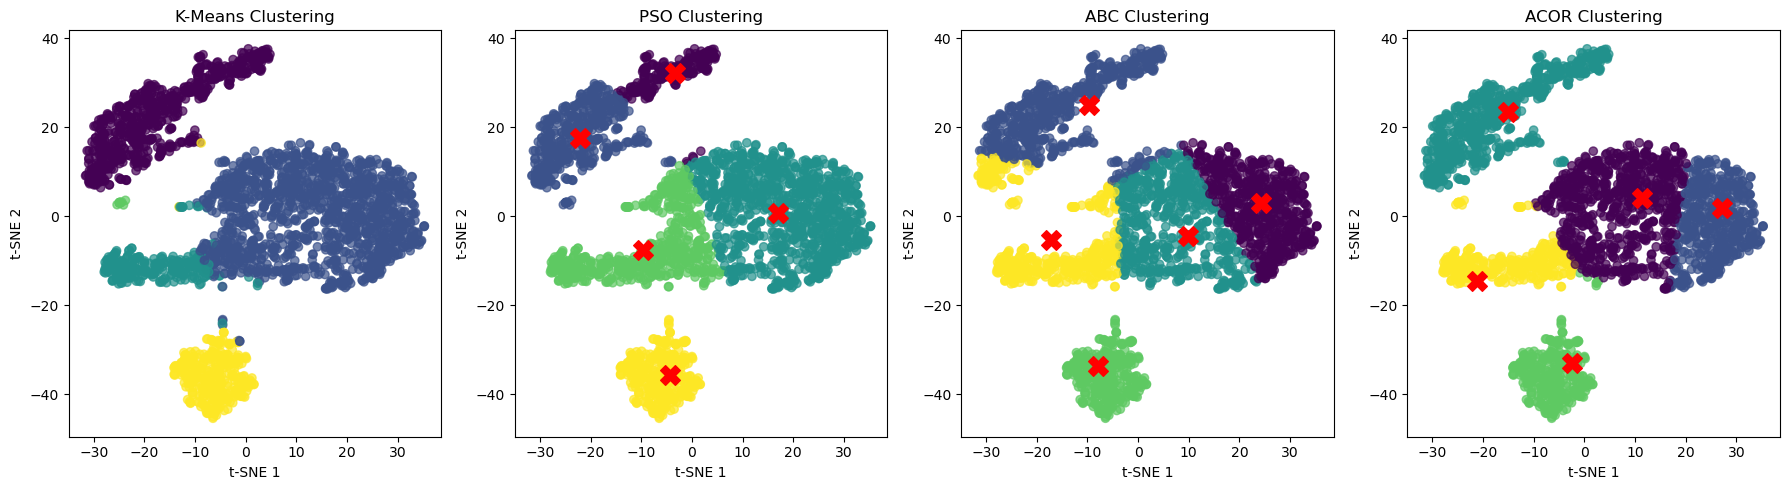

In [267]:
# -------------------------------
# 6. Visualization of Clustering Results
# -------------------------------
plt.figure(figsize=(18, 5))

plt.subplot(1, 4, 1)
SI.plot_clusters(data_tsne, clusters_df["Cluster"], kmeans_silhouette_score, title="K-Means Clustering")

plt.subplot(1, 4, 2)
SI.plot_clusters(data_tsne, pso_labels, pso_sil, title="PSO Clustering", centers=pso_centers)

plt.subplot(1, 4, 3)
SI.plot_clusters(data_tsne, abc_labels, abc_sil, title="ABC Clustering", centers=abc_centers)

plt.subplot(1, 4, 4)
SI.plot_clusters(data_tsne, acor_labels, acor_sil, title="ACOR Clustering", centers=acor_centers)

plt.tight_layout()
plt.show()

In [268]:
# -------------------------------
# 7. Print Comparison Summary
# -------------------------------
print("Clustering Comparison Results:")
for algo, res in results.items():
    print(f"{algo}: Cost = {res['cost']:.2f}, Silhouette Score = {res['silhouette']:.3f}")


Clustering Comparison Results:
KMeans: Cost = -1.00, Silhouette Score = 0.382
PSO: Cost = 289944.35, Silhouette Score = 0.508
ABC: Cost = 337574.30, Silhouette Score = 0.420
ACOR: Cost = 342302.43, Silhouette Score = 0.455


In [270]:
pd.DataFrame(results).T.to_csv("../results/pbmc3k/clustering_results.csv", index=True)